In [1]:
import pandas as pd

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

In [2]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%(AUTH['db_user'],AUTH['db_pass'],dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [7]:
boxscores = pd.read_sql("SELECT * FROM boxscores WHERE date >= '2019-10-22'", engine)
boxscores['ft_pct'] = boxscores.ftm/boxscores.fta
boxscores['fg_pct'] = boxscores.fgm/boxscores.fga

In [8]:
ft_pct_threshold = 0.75
fg_pct_threshold = 0.4
octys = boxscores.loc[(boxscores.assists > 0) & (boxscores.threes > 0) & (boxscores.steals > 0) & (boxscores.rebounds > 0) & (boxscores['blocks'] > 0) & (boxscores.ft_pct > ft_pct_threshold) & (boxscores.fg_pct > fg_pct_threshold)]
octys.shape

(383, 17)

In [9]:
octy_counts = pd.DataFrame(octys.name.value_counts())
octy_counts.reset_index(inplace=True)
octy_counts.rename(columns={'name':'octy_count', 'index':'name'}, inplace=True)

In [10]:
octys_games = pd.DataFrame(boxscores.groupby('name')['assists'].count())
octys_games.reset_index(inplace=True)
octys_games.rename(columns={'assists':'game_count'}, inplace=True)

In [12]:
merged = octy_counts.merge(octys_games, on='name')
merged['octy_pct'] = merged.octy_count / merged.game_count
merged.sort_values('octy_pct', ascending=False, inplace=True)

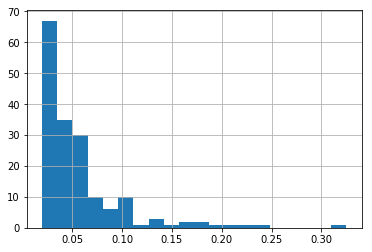

In [17]:
merged.octy_pct.hist(bins=20)

In [14]:
merged.head(50)

,name,octy_count,game_count,octy_pct
0,Anthony Davis,13,40,0.325000
2,Joel Embiid,8,33,0.242424
3,Kawhi Leonard,8,36,0.222222
16,Kyrie Irving,4,19,0.210526
1,James Harden,9,45,0.200000
5,Pascal Siakam,7,38,0.184211
19,John Collins,4,23,0.173913
4,Brandon Ingram,7,44,0.159091
8,Josh Richardson,6,38,0.157895
9,Kemba Walker,6,42,0.142857
